In [94]:
# Imports principaux
import pandas as pd
import numpy as np
from data_preprocess import DataPreprocessor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [95]:
# Chargement des données ETH et XBT
eth_path = "../data/features/DATA_0/ETH_EUR.parquet"
xbt_path = "../data/features/DATA_0/XBT_EUR.parquet"
df_eth = pd.read_parquet(eth_path)
df_xbt = pd.read_parquet(xbt_path)
print(f"ETH shape: {df_eth.shape}")
print(f"XBT shape: {df_xbt.shape}")

ETH shape: (1817685, 62)
XBT shape: (563395, 62)


In [96]:
df_eth

,bid-ask-imbalance-5-levels,spread,slope-bid-5-levels,slope-ask-5-levels,vwap-bid-5-levels,vwap-ask-5-levels,liquidity-ratio-5-levels,rate-inst-volatility-20-sample,rate-momentum-20-sample,rate-mid-price-trend-20-sample,...,level-6-ask-volume,level-7-ask-price,level-7-ask-volume,level-8-ask-price,level-8-ask-volume,level-9-ask-price,level-9-ask-volume,level-10-ask-price,level-10-ask-volume,timestamp
timestamp,,,,,,,,,,,,,,,,,,,,,
1.748488e+09,0.274159,0.01000,-0.003626,0.005356,0.0,0.0,1.755425,NaN,NaN,NaN,...,18.337426,2453.624144,0.528069,2453.696391,0.860901,2453.754018,5.518187,2453.852158,14.538000,1.748488e+09
1.748488e+09,0.513330,0.01000,-0.003626,0.006811,0.0,0.0,3.109557,NaN,NaN,NaN,...,36.240142,2453.530000,0.434709,2453.690000,0.621428,2453.700000,1.100373,2453.760000,9.936000,1.748488e+09
1.748488e+09,0.265161,0.01000,-0.003626,0.003511,0.0,0.0,1.721685,NaN,NaN,NaN,...,1.924000,2453.440000,36.240142,2453.530000,0.434709,2453.690000,0.621428,2453.700000,1.100373,1.748488e+09
1.748488e+09,0.320687,0.01000,-0.002743,0.003511,0.0,0.0,1.944153,NaN,NaN,NaN,...,1.924000,2453.440000,36.240142,2453.530000,0.434709,2453.690000,0.621428,2453.700000,1.100373,1.748488e+09
1.748488e+09,0.199271,0.01000,-0.002171,0.003511,0.0,0.0,1.497725,NaN,NaN,NaN,...,1.924000,2453.440000,36.240142,2453.530000,0.434709,2453.690000,0.621428,2453.700000,1.100373,1.748488e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.748523e+09,0.194011,0.14000,-0.012486,0.014387,0.0,0.0,1.481425,0.008172,-0.055000,2376.306553,...,2.600000,2377.060000,19.602000,2377.100000,23.167000,2377.220000,0.000653,2377.250000,26.737000,1.748523e+09
1.748523e+09,0.156433,0.22554,-0.021134,0.028554,0.0,0.0,1.370885,0.007689,-0.092770,2376.301914,...,11.101000,2377.081667,21.384500,2377.100003,11.583827,2377.249999,13.368827,2377.255792,13.870586,1.748523e+09
1.748523e+09,0.660999,0.64000,-0.014860,0.118312,0.0,0.0,4.899679,0.007998,-0.158925,2376.293968,...,19.602000,2377.100000,23.167000,2377.220000,0.000653,2377.250000,26.737000,2377.410000,1.004171,1.748523e+09


In [97]:
# Initialisation du DataPreprocessor
preprocessor = DataPreprocessor()

# Définition des colonnes features (XBT)
feature_columns = [
    "bid-ask-imbalance-5-levels",
    "V-bid-5-levels",
    "V-ask-5-levels",
    "slope-bid-5-levels",
    "slope-ask-5-levels"
]

target_column = "return-vs-volatility-5-ms"

# Préparation des données (split train/test inclus)
X_train, X_test, y_train, y_test = preprocessor.prepare_data(
    features_df=df_xbt,
    target_df=df_eth,
    feature_columns=feature_columns,
    target_column=target_column,
    test_size=0.2
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")
print(f"Label mapping: {preprocessor.get_label_mapping()}")

=== PRÉPARATION DES DONNÉES ADABOOST ===
Étape 1: Extraction du target 'return-vs-volatility-5-ms'...
Target shape: (1817685,)
Étape 2: Sélection des features...
Features sélectionnées: ['bid-ask-imbalance-5-levels', 'V-bid-5-levels', 'V-ask-5-levels', 'slope-bid-5-levels', 'slope-ask-5-levels']
Features shape avant dropna: (563395, 5)
Features shape après dropna: (562697, 5)
Étape 3: Alignement temporel avec np.searchsorted...
Features après filtrage: (1817685, 5)
Indices filtrés: 1817685
Étape 4: Création des DataFrames nettoyés...
Données après dropna et filtrage NaN: (1817685, 5)
Target après dropna et filtrage NaN: (1817685,)
Distribution des classes:
return-vs-volatility-5-ms
-1     107296
 0    1600454
 1     109935
Name: count, dtype: int64
Proportions des classes:
return-vs-volatility-5-ms
-1    0.059029
 0    0.880490
 1    0.060481
Name: proportion, dtype: float64
Étape 5: Conversion en arrays numpy...

=== RÉSULTAT FINAL ===
Features (X): (1817685, 5)
Labels encodés (y): (1

In [98]:
# Calcul des poids de classe pour gérer le déséquilibre
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print(f"Class weights: {class_weight_dict}")

# Période temporelle des données
print(f"\nPériode d'entraînement: index 0 à {len(X_train)-1}")
print(f"Période de test: index {len(X_train)} à {len(X_train)+len(X_test)-1}")

Class weights: {np.int64(0): np.float64(5.5649238823448375), np.int64(1): np.float64(0.37915624679777254), np.int64(2): np.float64(5.468428118548268)}

Période d'entraînement: index 0 à 1454147
Période de test: index 1454148 à 1817684


In [ ]:
# Initialisation et entraînement du modèle Random Forest (paramètres de Model_Mateo_1)
rf_model = RandomForestClassifier(
    n_estimators=100,  # Même nombre d'arbres que Model_Mateo_1
    max_depth=3,       # Même profondeur pour éviter l'overfitting
    class_weight="balanced",  # Gestion automatique du déséquilibre
    random_state=42,
    n_jobs=-1  # Utilise tous les cœurs disponibles
)

print("Entraînement du modèle Random Forest...")
rf_model.fit(X_train, y_train)
print("Modèle Random Forest entraîné!")

Entraînement du modèle Random Forest...


In [ ]:

# Prédictions et évaluation
y_pred = rf_model.predict(X_test)
y_train_pred = rf_model.predict(X_train)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_pred)

print(f"\n=== RÉSULTATS DU MODÈLE RANDOM FOREST ===")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Différence (overfitting): {train_acc - test_acc:.4f}")

# Utilisation des vraies classes présentes dans les données
actual_labels = sorted(np.unique(np.concatenate([y_test, y_pred])))
print(f"\nClasses présentes: {actual_labels}")

print("\n=== CLASSIFICATION REPORT (TEST SET) ===")
print(classification_report(y_test, y_pred, labels=actual_labels))

print("\n=== CONFUSION MATRIX (TEST SET) ===")
print(confusion_matrix(y_test, y_pred, labels=actual_labels))

print("Classes dans y_train:", np.unique(y_train))
print("Classes dans y_test:", np.unique(y_test))
print("Classes dans y_pred:", np.unique(y_pred))


=== RÉSULTATS DU MODÈLE RANDOM FOREST ===
Train Accuracy: 1.0000
Test Accuracy: 1.0000
Différence (overfitting): 0.0000

Classes présentes: [np.int64(0), np.int64(1)]

=== CLASSIFICATION REPORT (TEST SET) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    363535
           1       0.00      0.00      0.00         2

    accuracy                           1.00    363537
   macro avg       0.50      0.50      0.50    363537
weighted avg       1.00      1.00      1.00    363537


=== CONFUSION MATRIX (TEST SET) ===
[[363535      0]
 [     2      0]]
Classes dans y_train: [0]
Classes dans y_test: [0 1]
Classes dans y_pred: [0]


/raid/home/automatants/lahrach_cha/ChakibProjects/ifcob/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/raid/home/automatants/lahrach_cha/ChakibProjects/ifcob/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/raid/home/automatants/lahrach_cha/ChakibProjects/ifcob/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param


=== IMPORTANCE DES FEATURES ===
                      feature  importance
0  bid-ask-imbalance-5-levels         0.0
1              V-bid-5-levels         0.0
2              V-ask-5-levels         0.0
3          slope-bid-5-levels         0.0
4          slope-ask-5-levels         0.0


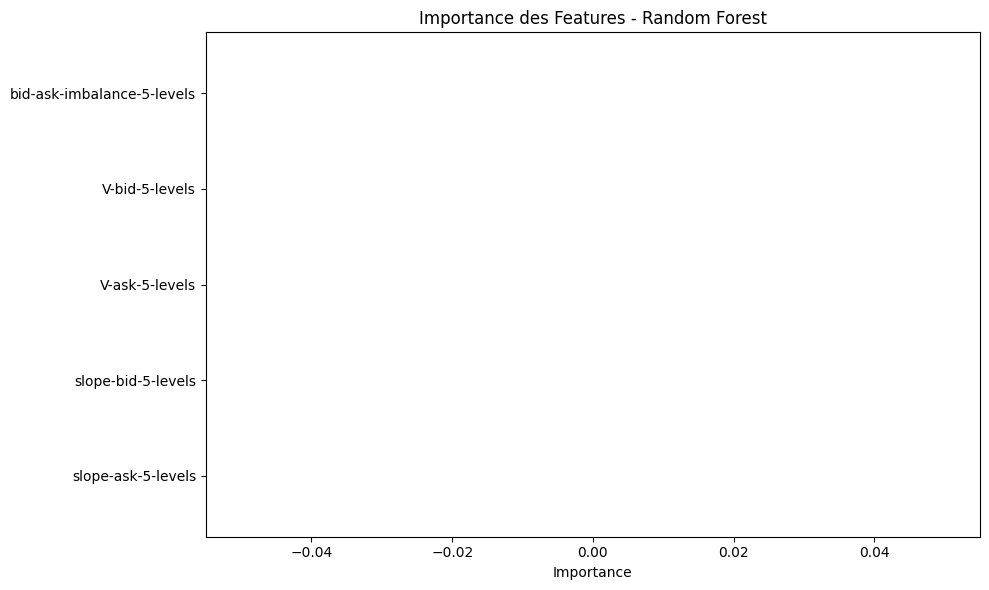

In [ ]:
# Analyse et visualisation des importances des features
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n=== IMPORTANCE DES FEATURES ===")
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Importance')
plt.title('Importance des Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

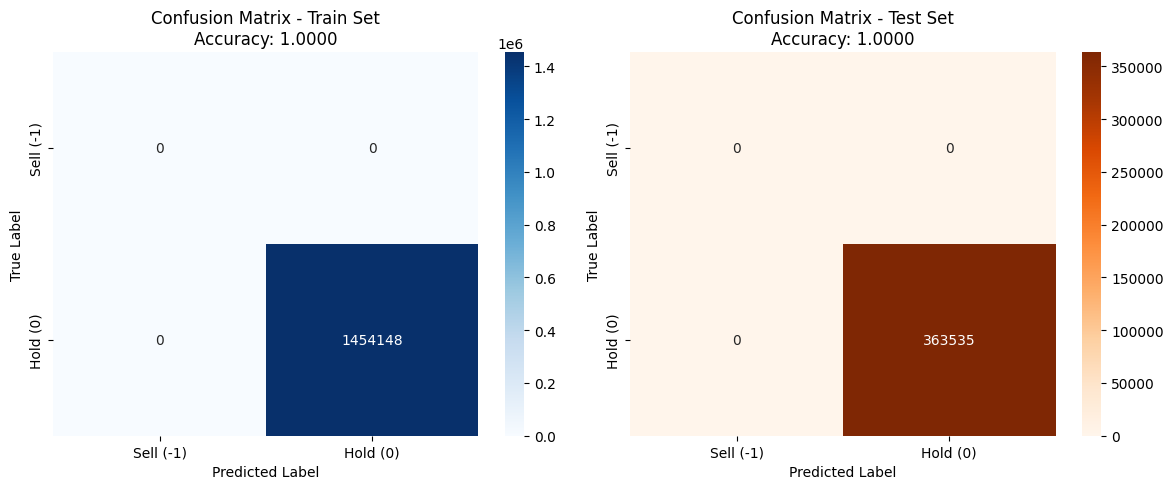

In [ ]:
# Visualisation des matrices de confusion
plt.figure(figsize=(12, 5))

# Matrice de confusion pour le train set
plt.subplot(1, 2, 1)
cm_train = confusion_matrix(y_train, y_train_pred, labels=[-1, 0])
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Sell (-1)', 'Hold (0)'], 
            yticklabels=['Sell (-1)', 'Hold (0)'])
plt.title(f'Confusion Matrix - Train Set\nAccuracy: {train_acc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Matrice de confusion pour le test set
plt.subplot(1, 2, 2)
cm_test = confusion_matrix(y_test, y_pred, labels=[-1, 0])
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Sell (-1)', 'Hold (0)'], 
            yticklabels=['Sell (-1)', 'Hold (0)'])
plt.title(f'Confusion Matrix - Test Set\nAccuracy: {test_acc:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()